# Hometask 6

Попробуйте обучить нейронную сеть U-Net на любом другом датасете. Напишите в комментариях к уроку, какого результата вы добились от нейросети, что помогло улучшить её точность?

In [1]:
!git clone https://github.com/tensorflow/examples.git
!ls -la

Cloning into 'examples'...
remote: Enumerating objects: 23104, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 23104 (delta 20), reused 48 (delta 12), pack-reused 23038
Receiving objects: 100% (23104/23104), 42.19 MiB | 17.16 MiB/s, done.
Resolving deltas: 100% (12669/12669), done.
total 20
drwxr-xr-x 1 root root 4096 Apr 26 16:45 .
drwxr-xr-x 1 root root 4096 Apr 26 16:43 ..
drwxr-xr-x 4 root root 4096 Apr 25 13:33 .config
drwxr-xr-x 7 root root 4096 Apr 26 16:45 examples
drwxr-xr-x 1 root root 4096 Apr 25 13:34 sample_data


In [3]:
# !python3 -m pip install git+http://github.com/tensorflow/examples.git

Установить tensorflow_examples в colab не удалось. Потрачена куча времени. Но похоже, что данные примеры в текущем варианте можно использовать без установки.

In [4]:
try:
    %tensorflow_version only exists in colab
except:
    pass
import tensorflow as tf

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [5]:
# import tensorflow.compat.v2 as tf

In [6]:
from __future__ import absolute_import, division, print_function, unicode_literals

# from examples.tensorflow_examples.model.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')

In [7]:
ds_names = ('oxford_iiit_pet:3.*.*', )
dataset_all, info = tfds.load(ds_names[0], split=['train[:10%]', 'test[-10%:]'], with_info=True)

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [8]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    sp

In [9]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [10]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [11]:
@tf.function
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [12]:
TRAIN_LENGHT = info.splits['train'].num_examples
BATCH_SIZE = 16
BUFFER_SIZE = 128
STEPS_PER_EPOCH = TRAIN_LENGHT // 10 // BATCH_SIZE

In [13]:
train = dataset_all[0].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset_all[1].map(load_image_test)

In [14]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [15]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    
    plt.show()

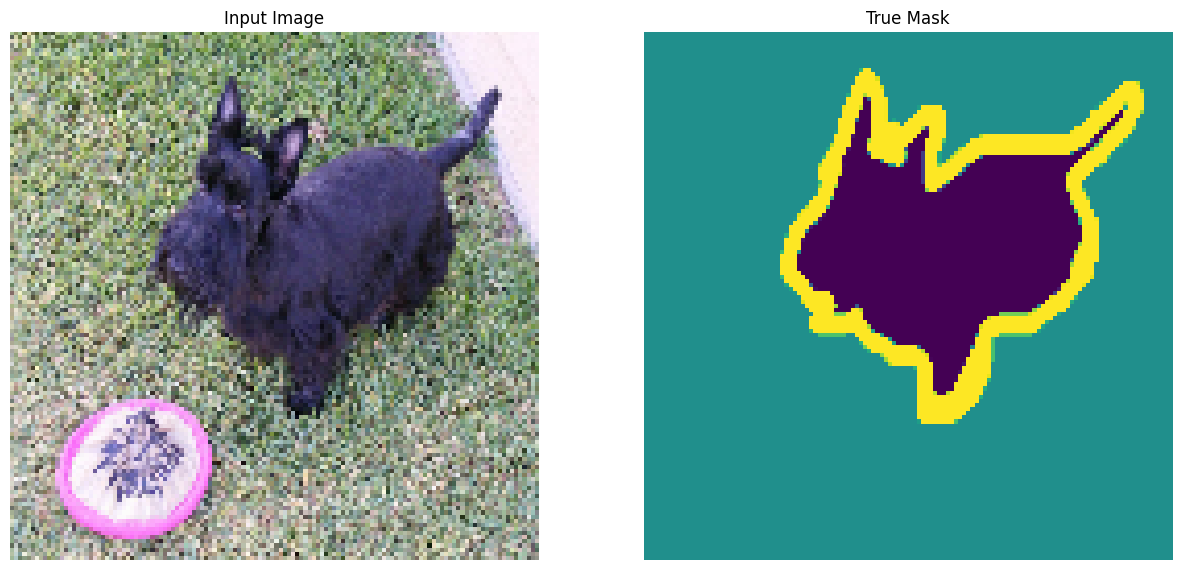

In [16]:
for image, mask in test_dataset.take(1):
    sample_image, sample_mask = image, mask
display([sample_image[1, :, :, :], sample_mask[1, :, :, :]])

In [18]:
sample_mask.numpy().min(), sample_mask.numpy().max()

(0.0, 2.0)

In [19]:
sample_mask.dtype

tf.float32

### Model U-Net

In [20]:
OUTPUT_CHANNELS = 3

In [21]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)
base_model.summary()

9406464/9406464 [==============================] - 2s 0us/step
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReL

In [22]:
layer_names = [
    'block_1_expand_relu', # 64x64
    'block_3_expand_relu', # 32x32
    'block_6_expand_relu', # 16x16
    'block_13_expand_relu', # 8x8
    'block_16_project'    # 4x4
]

layers = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [23]:
from examples.tensorflow_examples.models.pix2pix import pix2pix

In [27]:
up_stack = [
    pix2pix.upsample(512, 3), # 4x4 -> 8x8
    pix2pix.upsample(256, 3), # 8x8 -> 16x16
    pix2pix.upsample(128, 3), # 16x16 -> 32x32
    pix2pix.upsample(64, 3), # 32x32 -> 32x64
]

In [39]:
def unet_model(output_channels):
    inputs = tf.keras.Input(shape=[128, 128, 3])
    x = inputs

    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2, padding='same' # 64x64 -> 128x128
    )

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

### Training

In [41]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

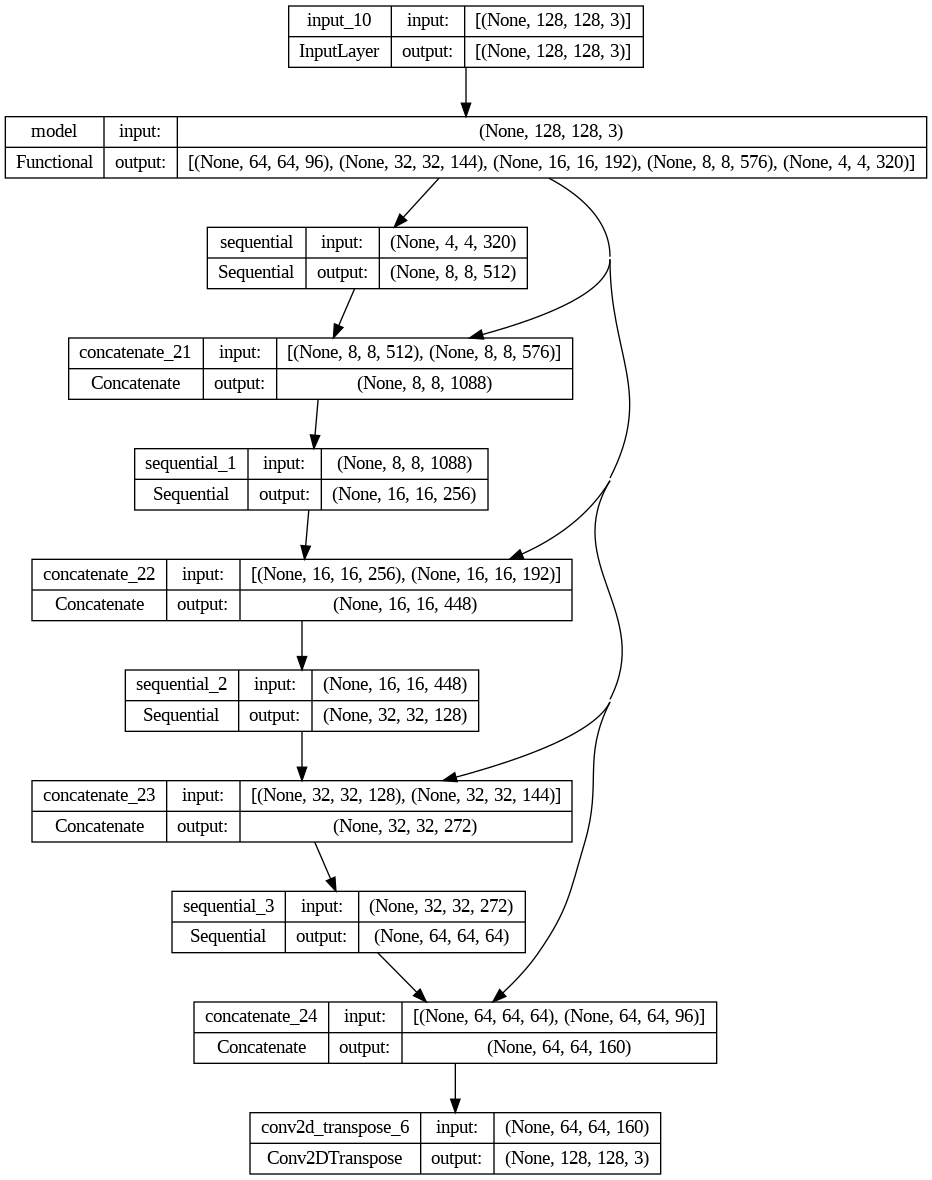

In [42]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Try predict

In [43]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [72]:
def show_predictions(dataset=None, num=1, start=0):
    if dataset:
        print('Dataset size = {}'.format(tf.data.experimental.cardinality(dataset).numpy()))
        i = 0
        for image, mask in dataset.take(num):
            i += 1
            if i < start + 1:
                continue
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image[0, :, :, :], sample_mask[0, :, :, :],
                 create_mask(model.predict(sample_image[:, :, :]))])

1/1 [==============================] - 0s 477ms/step


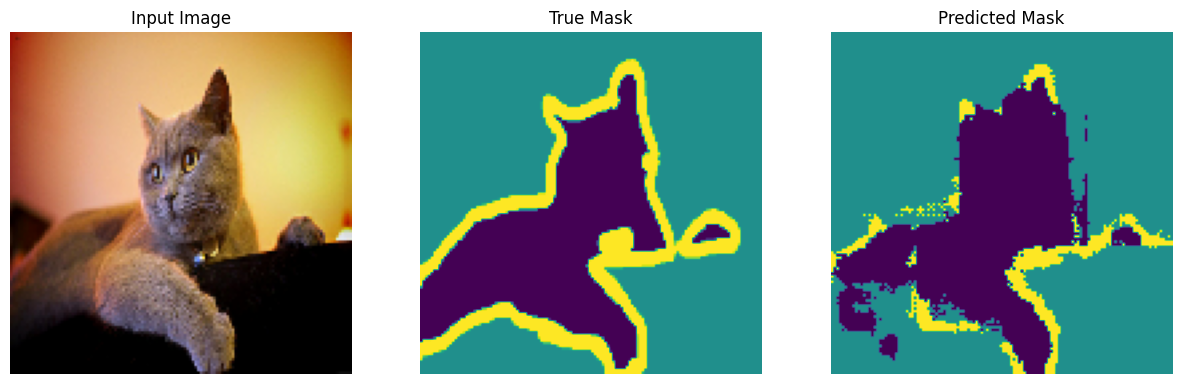

In [58]:
show_predictions()

In [46]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print('\nSample prediction after epoch {}\n'.format(epoch + 1))

In [47]:
EPOCHS = 5
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // 10 // BATCH_SIZE // VAL_SUBSPLITS

1/1 [==============================] - 0s 460ms/step


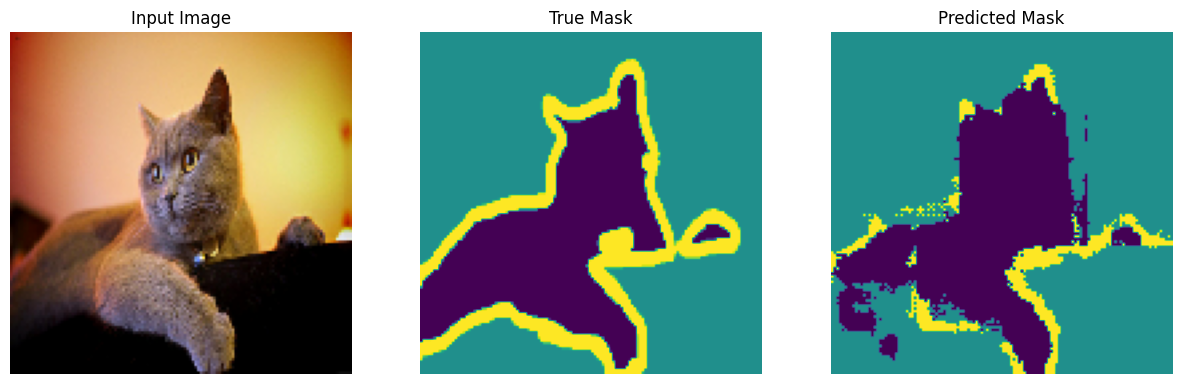


Sample prediction after epoch 5

23/23 [==============================] - 27s 1s/step - loss: 0.2908 - accuracy: 0.8808 - val_loss: 0.4449 - val_accuracy: 0.8372


In [48]:
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

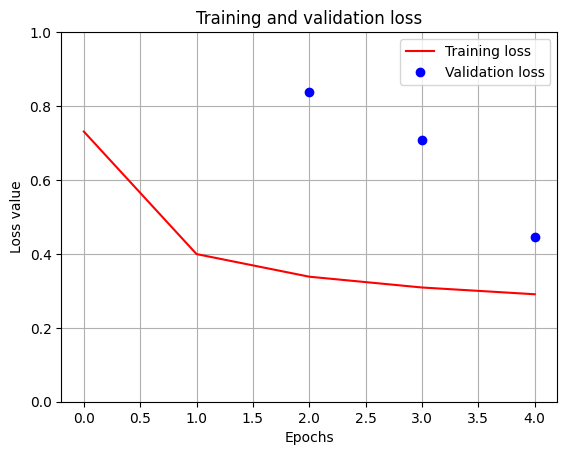

In [50]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel('Loss value')
plt.ylim([0, 1])
plt.grid('on')
plt.legend()
plt.show()

Dataset size = 23
1/1 [==============================] - 1s 760ms/step


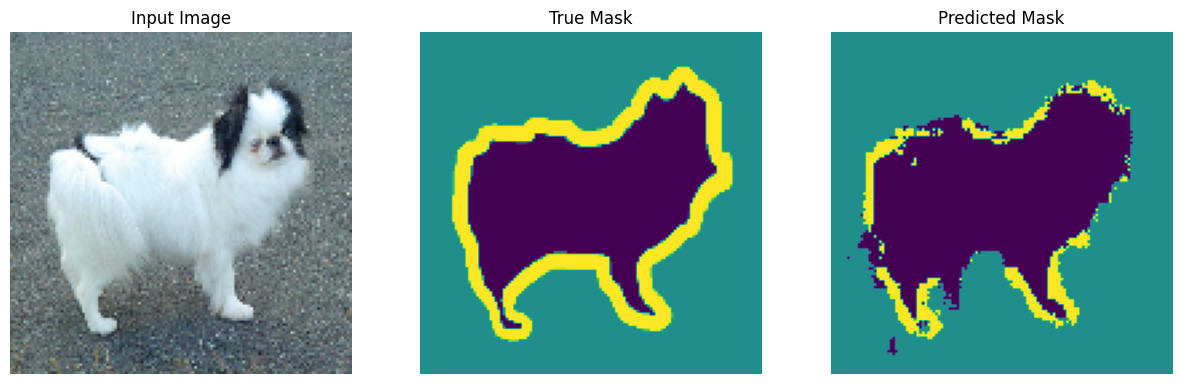

1/1 [==============================] - 0s 448ms/step


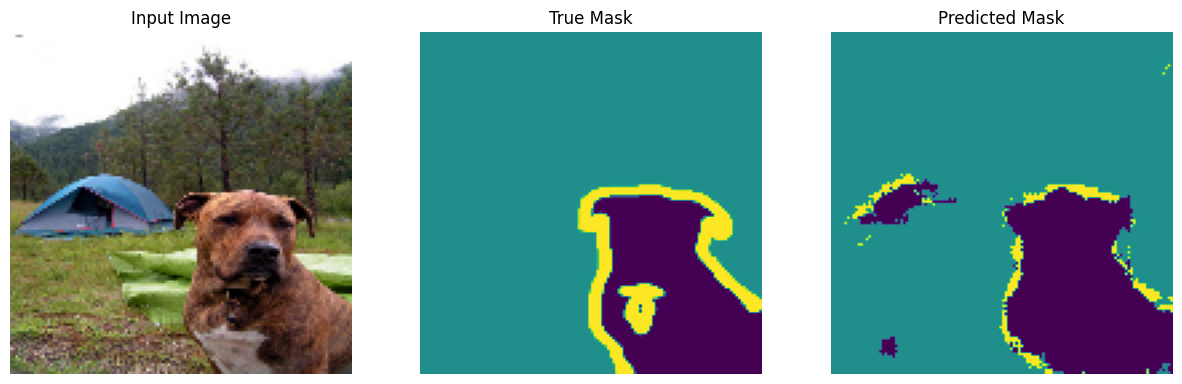

1/1 [==============================] - 0s 455ms/step


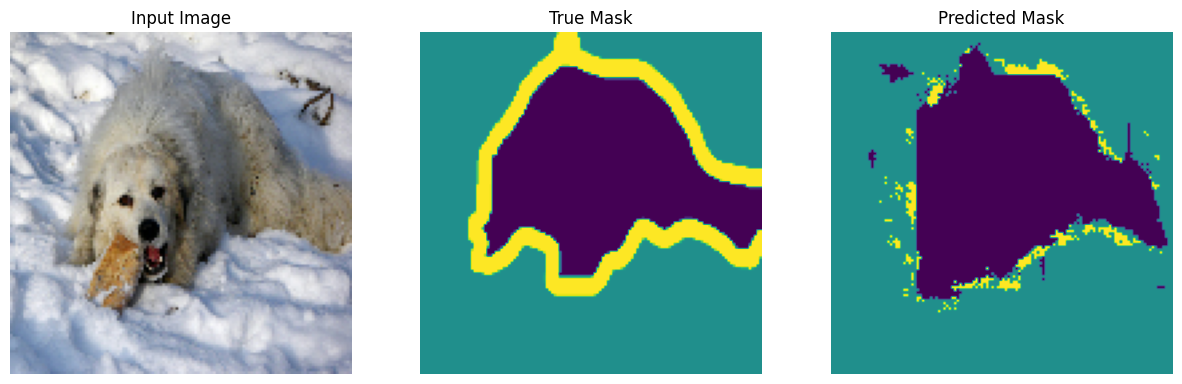

In [74]:
show_predictions(test_dataset, num=23, start=20)

### Tests

Попытка загрузки другого датасета с ходу не удалась. Птички отсутствуют (даже на исходном сайте). А cityscrapers требуюут регистрацию. В связи с чем ещё немного поучим готовую модель.

Т.к. метрика accuracy исходно получается очень большой, заменим её на коэффицией Дайса. Ожидается, что будет расти.

In [103]:
def dice_coef(y_true, y_pred):
    return (2. * tf.math.reduce_sum(y_true * y_pred) + 1.) / (tf.math.reduce_sum(y_true) + tf.math.reduce_sum(y_pred) + 1.)

In [104]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[dice_coef])

In [105]:
EPOCHS = 5
VAL_SUBSPLITS = 3
VALIDATION_STEPS = info.splits['test'].num_examples // 10 // BATCH_SIZE // VAL_SUBSPLITS

1/1 [==============================] - 0s 459ms/step


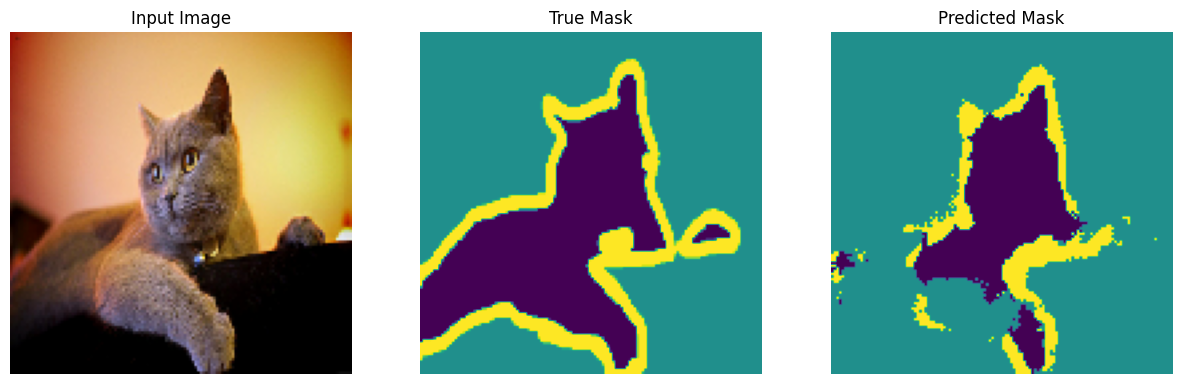


Sample prediction after epoch 5

23/23 [==============================] - 30s 1s/step - loss: 0.1932 - dice_coef: 2.4418 - val_loss: 0.4002 - val_dice_coef: 2.4344


In [106]:
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          shuffle=True,
                          callbacks=[DisplayCallback()])

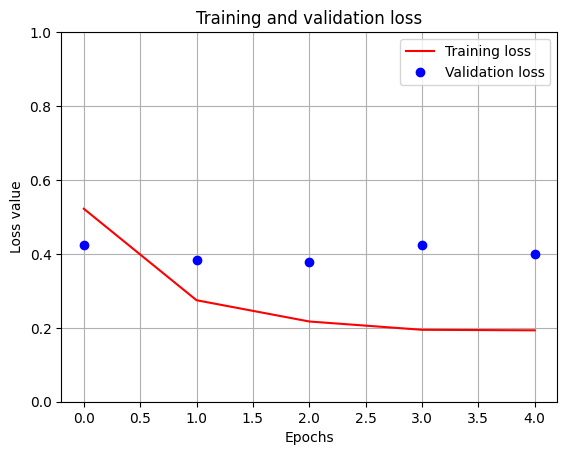

In [107]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel('Loss value')
plt.ylim([0, 1])
plt.grid('on')
plt.legend()
plt.show()

Функция потерь на обучении падает, что вроде как хорошо. Но на валидации плюс/минус. То ли мало эпох обучения, то ли из тех данных что есть (порядка 10% от всего датасета) сделано всё что возможно.

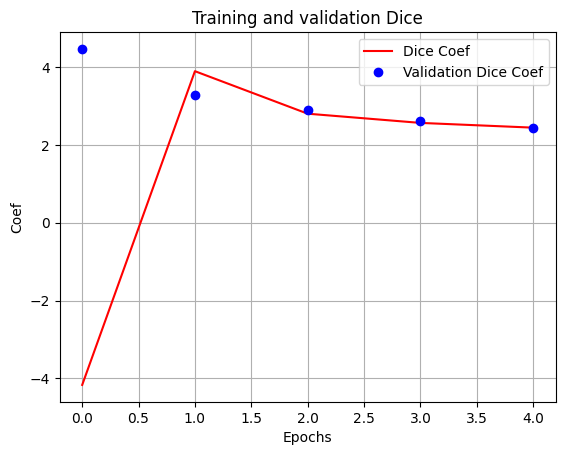

In [110]:
loss = model_history.history['dice_coef']
val_loss = model_history.history['val_dice_coef']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Dice Coef')
plt.plot(epochs, val_loss, 'bo', label='Validation Dice Coef')
plt.title('Training and validation Dice')
plt.xlabel("Epochs")
plt.ylabel('Coef')
plt.grid('on')
plt.legend()
plt.show()

Ожидается, что коэффициент ДАйса будет расти, но он стал немного падать, как на обучении, так и на валидации. Те же выводы что и выше (то ли мало обучения, то ли уже всё что могли обучили).

In [112]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='Adamax',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[dice_coef])

In [113]:
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // 10 // BATCH_SIZE // VAL_SUBSPLITS

1/1 [==============================] - 1s 747ms/step


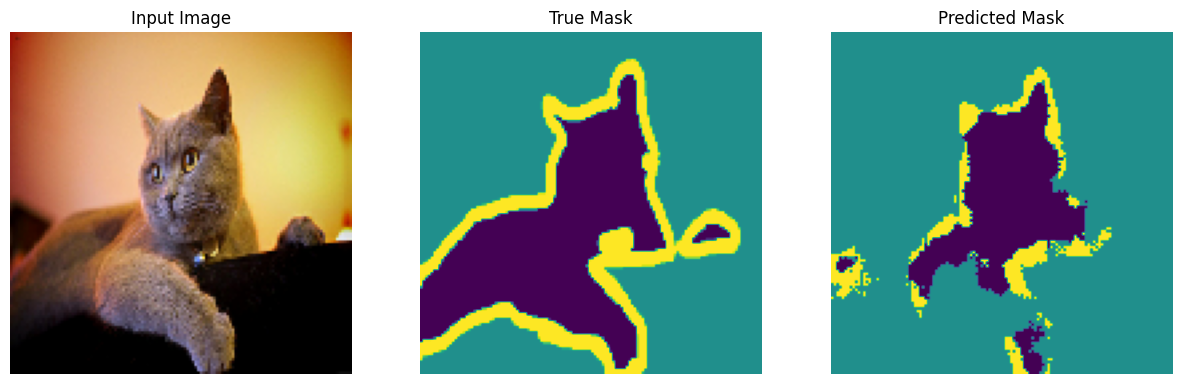


Sample prediction after epoch 10

23/23 [==============================] - 28s 1s/step - loss: 0.1206 - dice_coef: 5.3247 - val_loss: 0.3920 - val_dice_coef: 28.5774


In [114]:
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          shuffle=True,
                          callbacks=[DisplayCallback()])

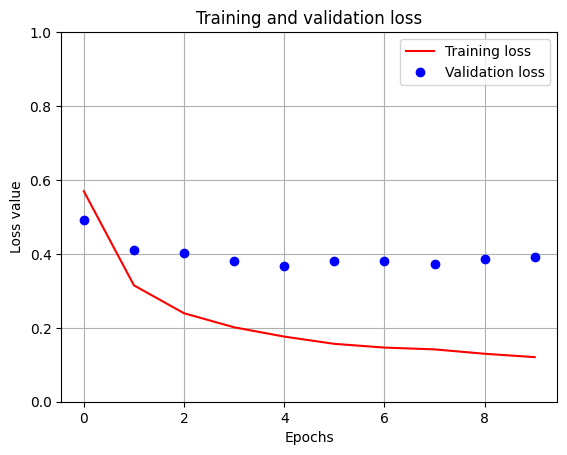

In [115]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel('Loss value')
plt.ylim([0, 1])
plt.grid('on')
plt.legend()
plt.show()

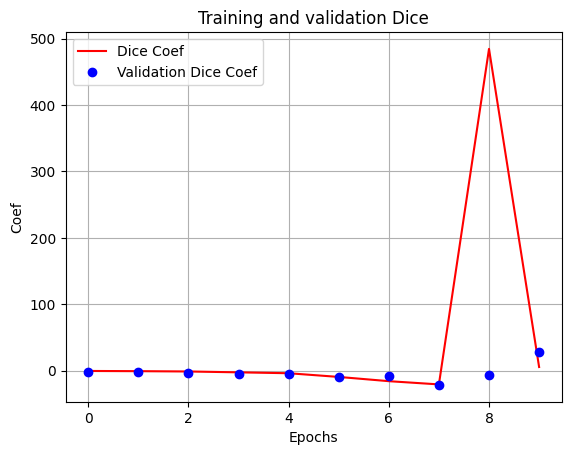

In [116]:
loss = model_history.history['dice_coef']
val_loss = model_history.history['val_dice_coef']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Dice Coef')
plt.plot(epochs, val_loss, 'bo', label='Validation Dice Coef')
plt.title('Training and validation Dice')
plt.xlabel("Epochs")
plt.ylabel('Coef')
plt.grid('on')
plt.legend()
plt.show()

Интересные результаты. Судя по всему количества эпох и не хвататает. Не то чтобы наметился тренд на стабильное улучшение метрики. Но всё же что-то начало прослеживаться.

Выводы: основным результатом можно считать, что для маленького датасета надо делать больше обучения. Т.к. валидационная выборка и выборка для обучения сильно различаются. Применение правильных метрик обеспечит корректную оценку результатов. Можно и скорее всего нужно увеличить количество данных для обучения. Правда, здесь следует учесть размер батча. Эффективнее всего будет использовать макисмально большой батч, на сколько позволит память устройства на котором идёт обучения. Но в то же время в ходе экспериментов в других работах было установлено, что максимальный батч не всегда эффективен. Зато скорость обучения можно увеличить.

PS на tensorflow-examples ушло много времени. Приходится заниматься не только экспериментами, а ещё и девопс частью. Хорошо что есть colab. Но как оказалось и в нём не всегда всё можно использовать.